# Colouring the World Map with a genetic algorithm

In this NB we will show a simple genetic algorithm to color the World Map with a set of colors in such a way that adjacent countries always have different colors. For a nice introduction to the problem see: https://mathigon.org/course/graph-theory/map-colouring

- The exercise involves:

1. Reading a Map in json format. https://www.json.org/json-en.html
2. Building a graph which contains all the relevant information to manipulate the map, including the links between countries. We will use networkx for this purpose: https://networkx.github.io/
3. To draw the map and to find out whether countries (represented as geometric shapes such as Polygons and MultiPolygons) are adjancent or not, we will need the shapely library: https://pypi.org/project/Shapely/
3. Designing a genetic algorithm to color the map. 

## Import needed modules

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import urllib.request
import random
import datetime
from typing              import List, Dict, Tuple, Sequence, Callable
from networkx            import Graph
from matplotlib.patches  import Polygon
from shapely.geometry    import shape, MultiPolygon, LineString, MultiLineString

## Obtaining the World map (or other maps) in format json

- Go to https://geojson-maps.ash.ms/ and follow instructions. Copy the json map in the same directory of this NB

- For this NB we will use:
    - A World Map called world.json
    - A Map of Africa called africa.json

## Stucture of the maps

- Click on the map files (world.json, africa.json...). Jupyter speaks json and will show the structure of the file.
    - The type of the file is "FeatureCollection"
    - It contains a number of features (equal to the number of countries in the map)
    - Opening each feature of the Feature collection (that is looking at the structure of each country) we see two objects of type Feature they are:
        - properties
        - geometry
    - Propeties contain a dictionary of key:values characterizing the country.
    - Geometry contains a description of the geometry, which indicates:
        - The type of the object (Polygon or MultiPolygon)
        - The coordinates. 

## Reading and dumping the map

- Reading is performed by a function of the json library.
- We can write a function view_map_data() which views (dumps) the structure of the file

### Code 

In [2]:
def load_map_data(file='world.json'):
    """Loads json map data file"""
    
    with open(file) as f:
        data = json.load(f)
    return data


In [3]:
def view_map_data(data, ic=1):
    """Displays the structure of the map data file"""
    
    features = data['features']
    nb_countries = len(features)
    
    print(f'number of countries in map = {nb_countries}')
    
    print(f'view data for = {ic} countries')
    
    for idx in range(ic):
        props = features[idx]['properties']
        geom = features[idx]['geometry']
        country_geo = shape(geom)
        print(f'country number = {idx}')
        print(f'country properties = {props}')
        print(f'country geometry represented by {country_geo}')
        
 

### Test

In [4]:
jmap_name = 'world.json'
print(f'loading {jmap_name} map')
jmap = load_map_data(file=jmap_name)
print(f'viewing {jmap_name} map')
view_map_data(jmap, ic=2)

loading world.json map
viewing world.json map
number of countries in map = 175
view data for = 2 countries
country number = 0
country properties = {'scalerank': 1, 'featurecla': 'Admin-0 country', 'labelrank': 4, 'sovereignt': 'The Bahamas', 'sov_a3': 'BHS', 'adm0_dif': 0, 'level': 2, 'type': 'Sovereign country', 'admin': 'The Bahamas', 'adm0_a3': 'BHS', 'geou_dif': 0, 'geounit': 'The Bahamas', 'gu_a3': 'BHS', 'su_dif': 0, 'subunit': 'The Bahamas', 'su_a3': 'BHS', 'brk_diff': 0, 'name': 'Bahamas', 'name_long': 'Bahamas', 'brk_a3': 'BHS', 'brk_name': 'Bahamas', 'brk_group': None, 'abbrev': 'Bhs.', 'postal': 'BS', 'formal_en': 'Commonwealth of the Bahamas', 'formal_fr': None, 'note_adm0': None, 'note_brk': None, 'name_sort': 'Bahamas, The', 'name_alt': None, 'mapcolor7': 1, 'mapcolor8': 1, 'mapcolor9': 2, 'mapcolor13': 5, 'pop_est': 309156, 'gdp_md_est': 9093, 'pop_year': -99, 'lastcensus': 2010, 'gdp_year': -99, 'economy': '6. Developing region', 'income_grp': '2. High income: nonOECD',

## Building a "Graph" Map

- The next step is to build a graph from the json map. For that purpose we will use the networkx library. We will call the resulting map a gMap (graph-Map). 
- A Graph is defined by a set of nodes (which may have an arbitrary number of properties), connected by edges. 
- Our graph map assigns a node to each country, with several properties. From the json map we will for now, copy the name and geometry. 
- To build the graph itself, we define an adjacency matrix. This is a square matrix of shape (nc x nc), where nc is the number of countries. If country i is adjacent to country j, the element ij of the matrix is 1, otherwise is zero. By convention a country is not adjacent to itself, so ii = 0. 

### Code:

In [7]:
def build_gmap(jmap, mapName: str ='World Map', imax : int=0)->Graph:
    """Takes a jmap and returns a gMap (an object of type graph) representing the map including
    network information
    """
    
    def adjacency_test(country_geo1 : Polygon, country_geo2 : Polygon)->bool:
        """Returns True if the two countries are adjacent. Takes adavantage of
        the properties of Polygons (shape library objects), which "know" if they 
        intersect. 
        
        """
        return not country_geo1.intersection(country_geo2).is_empty

    def build_pols():
        """The geometrical object representing the geometry can be
        Polygons or a collection of Polygons (MultiPolygon). To pass the information to 
        matplotlib we need a list of polygons. This function fills the dictionary
        name_pols with a list of polygons representing the country
        
        """
        if country_geo.geom_type == "MultiPolygon":
            polygons       = list(country_geo)
        elif country_geo.geom_type == "Polygon":
            polygons = [country_geo]
        else:
            print(f'found unexpected type, geom = {country_geo.geom_type}')
        
        name_pols[idx] = polygons
    
    def build_graph():
        """Builds a graph from the adjacency matrix and adds properties """
        
        G = nx.Graph(np.array(admat))
        G.graph['name'] = mapName
    
        print(f'built map graph, len = {len(G)}')
    
        for i in G.nodes:
            G.nodes[i]['name'] =name_map[i]
            G.nodes[i]['pols'] = name_pols[i]
            
        return G
 
        
    features     = jmap['features']
    nb_countries = len(features)
    name_map     = {}
    name_pols    = {}
    amat         = []
    
    print(f'number of countries in map = {nb_countries}')
    
    for idx in range(nb_countries):
        country_name = features[idx]['properties']['name']
        name_map[idx] = country_name
        geom = features[idx]['geometry']
        country_geo = shape(geom)
        
        if idx < imax:
            print(f' idx = {idx}, country = {country_name}, shape = {country_geo.geom_type}')
  
        build_pols()
    
        lst = []
        for oidx in range(nb_countries):
            other_name = features[oidx]['properties']['name']
            geom = features[oidx]['geometry']   
            other_geo = shape(geom)
            
            if oidx < imax:
                print(f' oidx = {oidx}, country = {other_name}, shape = {other_geo.geom_type}')
                print(f'adjacency test = {adjacency_test(country_geo, other_geo) and country_name != other_name}')
 
            if adjacency_test(country_geo, other_geo) and country_name != other_name:
                lst.append(1)
            else:
                lst.append(0)
                
        amat.append(lst)
    
    admat = np.array(amat)
    print(f'built adjancency matrix, shape = {admat.shape}')
    
    return build_graph()
   

### Test

In [8]:
wMap = build_gmap(jmap, mapName='World Map', imax =0)

number of countries in map = 175
built adjancency matrix, shape = (175, 175)
built map graph, len = 175


## Plot the World map with a single color

- We have now enough info to plot the WM with a single color, just using the geometrical info

## Code

In [9]:
def plot_gmap_monocolor(gMap : Graph, facecolor = 'gray', figsize=(30, 15)):
    """We use matplotlib to plot the collection of polygons in the map. We choose gray as color"""
    
    fig, ax = plt.subplots(figsize=figsize)
    
    POLS = list(gMap.nodes(data="pols")) # this provides [(0, lpol), (1, lpol)...]
    for lpol in POLS:
        for polygon in lpol[1]: # (0, pol) --> (0, list-of-polygons)
            mpl_poly = Polygon(np.array(polygon.exterior), facecolor=facecolor, 
                               linewidth=5.0, alpha=0.5, edgecolor='black')
            ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale()
    ax.axis('off')
    #return fig


## Test

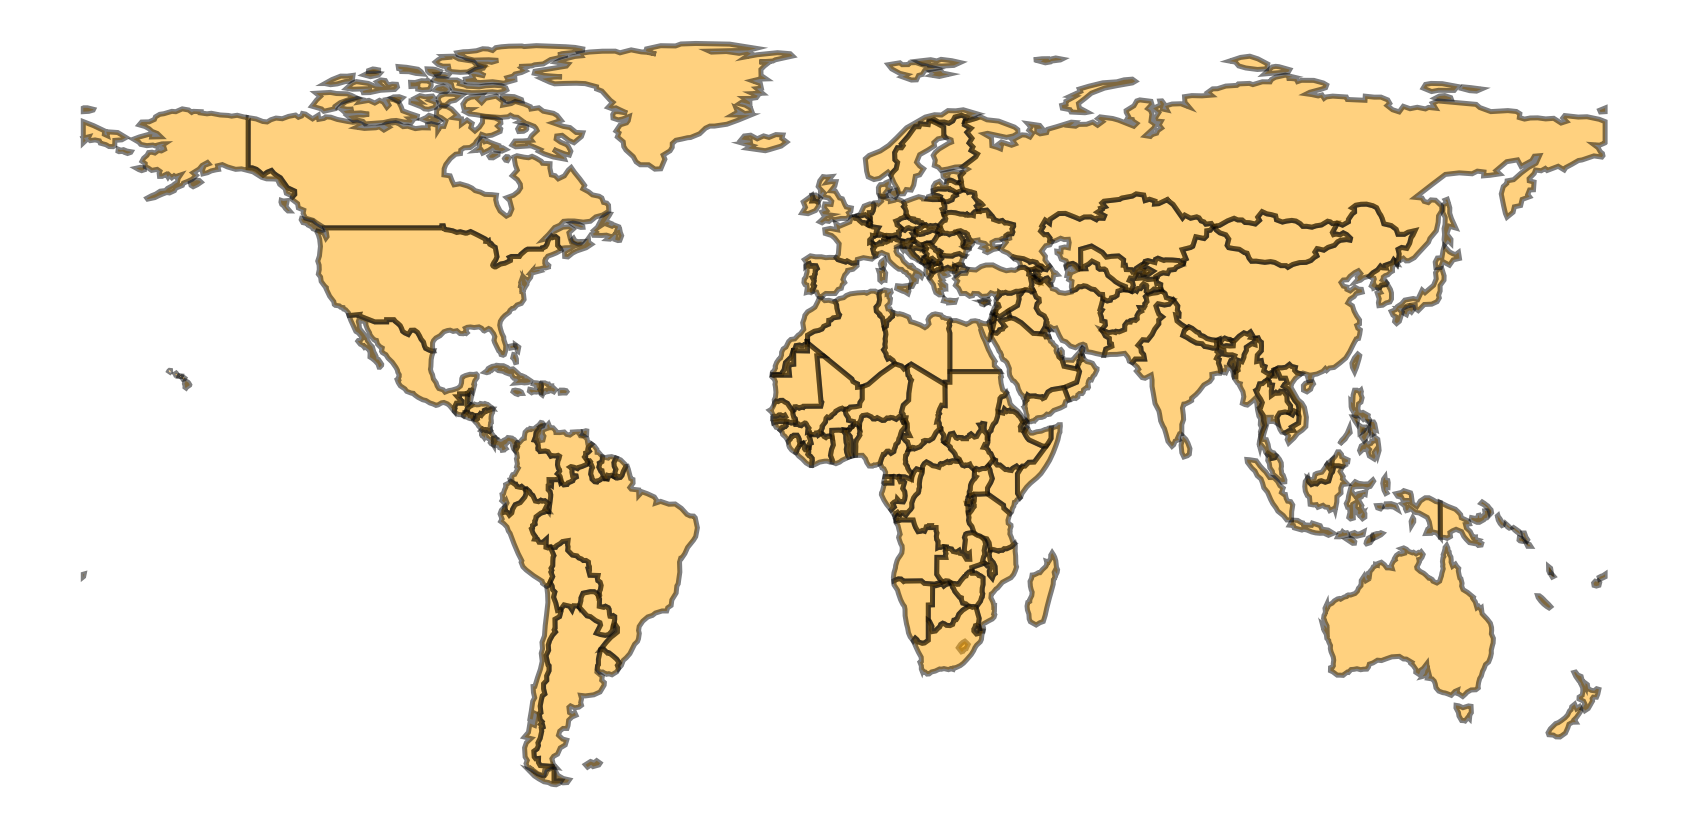

In [10]:
plot_gmap_monocolor(wMap, facecolor = 'orange', figsize=(30, 15))

## Plot the World map with a set of colors

- The next step is to add a color as a property to each node, then add colors to our GMap and plot it.

## Code

In [11]:
def add_colors_to_gmap(gMap : Graph, colors : List):
    """Add a list of colors (one per node) to the gMap """
    for i in gMap.nodes:
        gMap.nodes[i]['color'] = COLORS[colors[i]]


## Data

In [12]:
colset = range(6) # five colors

COLORS = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'magenta',
}


## Generate colors

- To generate colors for the map we write a function that takes the color-set and generates randomly as many colors as countries. In fact, this function is also the first function of our "genetic algorithm".

### Code

In [13]:
def generate_parent_genes(length: int, geneSet: Sequence)->List:
    """This function generates a list of genes (with length = length) from a gene set"""
    genes = []
    while len(genes) < length:
        sampleSize = min(length - len(genes), len(geneSet))
        genes.extend(random.sample(geneSet, sampleSize))
    return genes


### Test

In [14]:
colors = generate_parent_genes(len(wMap), colset)
cols =[COLORS[i] for i in colors]
print(f'generate a list of {len(colors)} colors = {cols}')

generate a list of 175 colors = ['red', 'green', 'yellow', 'orange', 'magenta', 'blue', 'red', 'yellow', 'blue', 'magenta', 'orange', 'green', 'magenta', 'green', 'yellow', 'orange', 'blue', 'red', 'orange', 'red', 'magenta', 'yellow', 'green', 'blue', 'blue', 'yellow', 'orange', 'green', 'red', 'magenta', 'green', 'yellow', 'orange', 'red', 'blue', 'magenta', 'orange', 'green', 'magenta', 'blue', 'red', 'yellow', 'orange', 'magenta', 'green', 'yellow', 'blue', 'red', 'green', 'orange', 'yellow', 'blue', 'magenta', 'red', 'yellow', 'green', 'blue', 'orange', 'red', 'magenta', 'yellow', 'green', 'magenta', 'red', 'orange', 'blue', 'red', 'orange', 'magenta', 'yellow', 'blue', 'green', 'blue', 'magenta', 'green', 'orange', 'red', 'yellow', 'magenta', 'orange', 'red', 'blue', 'green', 'yellow', 'orange', 'yellow', 'magenta', 'red', 'blue', 'green', 'yellow', 'magenta', 'red', 'orange', 'green', 'blue', 'blue', 'yellow', 'green', 'orange', 'magenta', 'red', 'magenta', 'orange', 'blue', 'ye

## We can add now the colors to the map

In [15]:
add_colors_to_gmap(wMap, colors)

## Plotting a color map

- We can now take the colors generated above and assign them to countries to produced a coloured World Map.

## Code

In [16]:
def plot_gmap_color(wMap : Graph,figsize=(30, 15)):
    """Plot a color map using matplotlib. If not color is found use gray"""
    
    fig, ax = plt.subplots(figsize=figsize)
    
    POLS = list(wMap.nodes(data="pols"))
    cols = list(wMap.nodes(data="color"))
    for i, lpol in enumerate(POLS):
        for polygon in lpol[1]:
            col = cols[i][1]
            if col == None:
                facecolor = 'gray'
            else:
                facecolor = col
            
            mpl_poly = Polygon(np.array(polygon.exterior), 
                               facecolor=facecolor, 
                               linewidth=5.0, alpha=0.5, edgecolor='black')
            ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale()
    ax.axis('off')
   


## Test

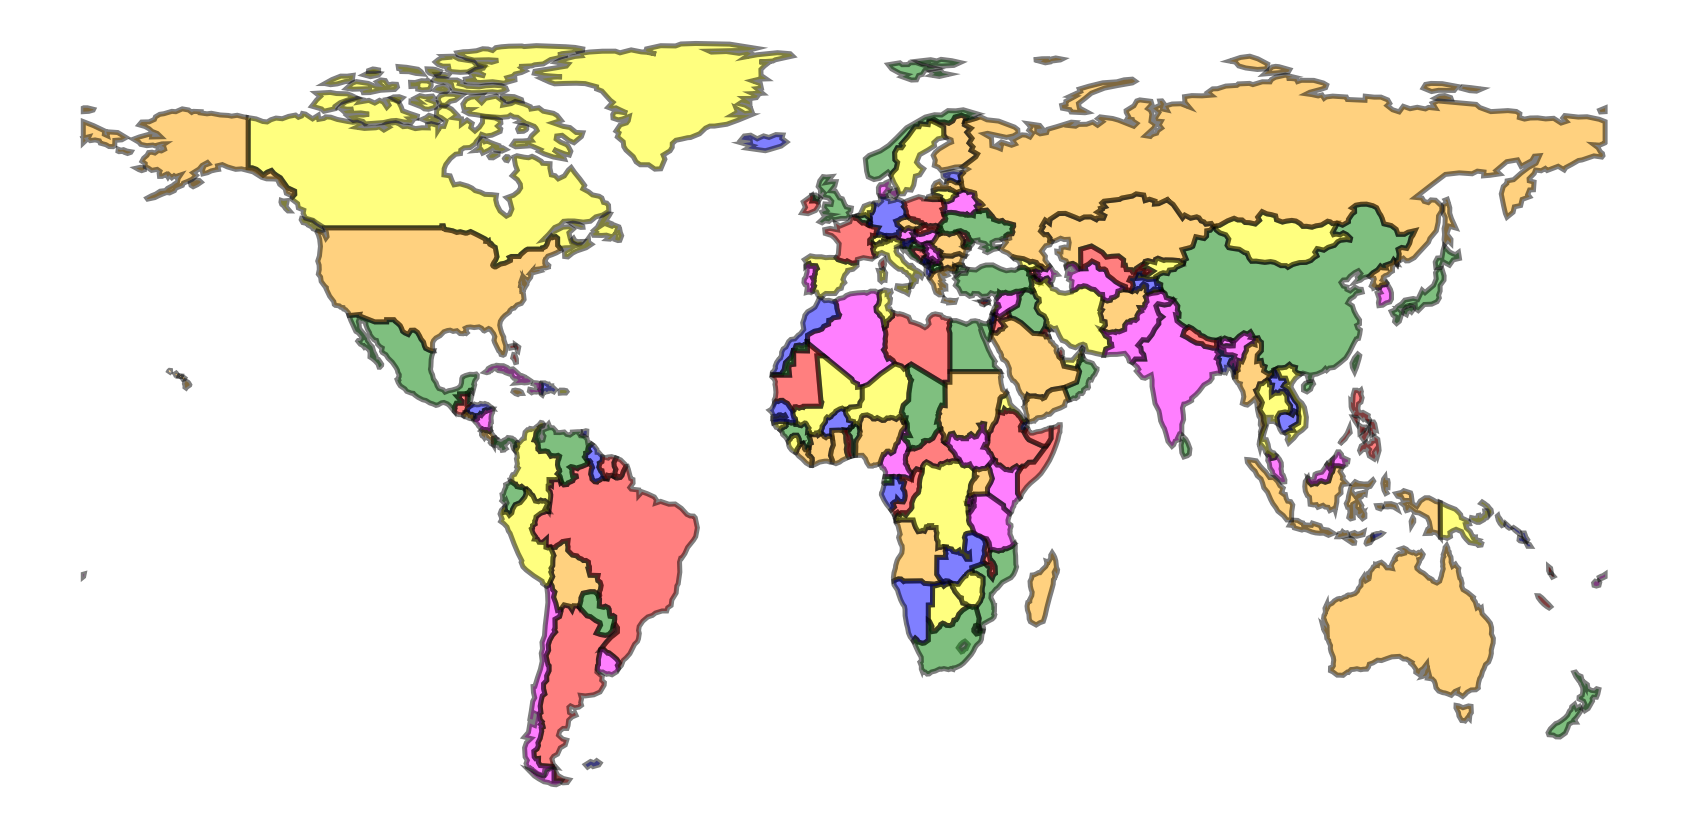

In [17]:
plot_gmap_color(wMap,figsize=(30, 15))

## Colouring the map with a genetic algorithm

- The final step is to implement a genetic algorithm to color the map. The algorithm does the following:
    - Generates an initial set of genes (colors) from the gene set. 
    - Evaluates the fitness of this set of genes and compares it with the optimal fitness. If the fitness is equal to optimal fitness, terminates
        - Otherwise, generate a new set of genes, mutating one gene at the time.
        - For each new set of genes evaluate fitness and retain the set if better or equal to that of the previous set. 
    - The algorithm also terminates if a given number of iterations is exceeded, to avoid infinite loops
    
- The fitness function is computed by iterating over all countries (nodes) in the map. For each country one follows all the edges (links) which lead to neighbhouring countries. If the color of the node and the color of the country pointed to by the edge are not the same, the fitness increases by one unit. 

- Each edge contains two colors (the color of the node and the color of the country the edge points to), so the optimal fitness is the number of edges x 2. 

## Code

In [18]:
def mutate_genes(genes: List, geneSet: List)->List:
    """Mutate genes, choosing a new gene from geneSet"""

    mutatedGenes         = genes[:]
    index                = random.randrange(0, len(mutatedGenes))
    newGene, alternate   = random.sample(geneSet, 2)
    mutatedGenes[index]  = alternate if newGene == mutatedGenes[index] else newGene
    return mutatedGenes


def fitness(gMap: Graph, imax=0)->float:
    """Fitness function: 
    1. For each node in map it finds all the edges
    2. Compares the color of the node with the color of each node pointed by the edge
    3. Increases by one unit if the colors are not the same
    
    """
    ft = 0
    for i in gMap.nodes:           
        edges = gMap.edges([i]) # This returns [(i, j1), (i, j2)...] where (j1, j2) are the neighbours
        if i < imax:
            print(f"node = {i}, country = {gMap.nodes[i]['name']}, color = {gMap.nodes[i]['color']}")
            print(f"edges = {edges}")
 
        for e in edges:
            j = e[1] # index of neighbour 
            if gMap.nodes[i]['color'] != gMap.nodes[j]['color']:
                ft+=1
                
            if i < imax:
                print(f"node = {j}, country = {gMap.nodes[j]['name']}, color = {gMap.nodes[j]['color']}")
                print(f"fitness = {ft}")

             
    return ft



## Tests

### Compute the fitness of the first color set (map above). Note that the color has been added to the map

In [19]:
ft = fitness(wMap, imax=10)
print(f'fitness = {ft}')

node = 0, country = Bahamas, color = red
edges = []
node = 1, country = Belize, color = green
edges = [(1, 6), (1, 11)]
node = 6, country = Guatemala, color = red
fitness = 1
node = 11, country = Mexico, color = green
fitness = 1
node = 2, country = Canada, color = yellow
edges = [(2, 26)]
node = 26, country = United States, color = orange
fitness = 2
node = 3, country = Costa Rica, color = orange
edges = [(3, 12), (3, 13)]
node = 12, country = Nicaragua, color = magenta
fitness = 3
node = 13, country = Panama, color = green
fitness = 4
node = 4, country = Cuba, color = magenta
edges = []
node = 5, country = Dominican Rep., color = blue
edges = [(5, 9)]
node = 9, country = Haiti, color = magenta
fitness = 5
node = 6, country = Guatemala, color = red
edges = [(6, 1), (6, 8), (6, 11), (6, 15)]
node = 1, country = Belize, color = green
fitness = 6
node = 8, country = Honduras, color = blue
fitness = 7
node = 11, country = Mexico, color = green
fitness = 8
node = 15, country = El Salvador,

### We can now mutate the genes, add the colors to the map and recompute fitness.

In [20]:
colors2 = mutate_genes(colors, colset)

In [21]:
add_colors_to_gmap(wMap, colors2)

In [22]:
ft = fitness(wMap, imax=0)
print(f'fitness = {ft}')

fitness = 534


## Optimal fitness

In [23]:
optimalFitness = len(wMap.edges) * 2
print(f'optimalFitness = {optimalFitness}')

optimalFitness = 616


## Optimize function

- Finally we write the optimize function

### Code

In [24]:
def optimize(gMap : Graph, geneSet : List, get_fitness : Callable, optimalFitness : float,
             verbose=True, imax=10000):
    """The optimize function:
    1. Starts with a random gene sequence from the gene Set
    2. keeps mutating genes until optimal fitness is achieved
    """

    random.seed()
    startTime = datetime.datetime.now()
    guess = generate_parent_genes(len(gMap), geneSet)
    add_colors_to_gmap(gMap, guess)
   
    print(f'First guess = {guess}')

    i = 0
    ifmax = 0
    if verbose:
        ifmax = 10
    
    f = get_fitness(gMap, ifmax)
    
    ifmax = 0
    while f < optimalFitness and i < imax:
        newGuess = mutate_genes(guess, geneSet)
        add_colors_to_gmap(gMap, newGuess)
        fn = get_fitness(gMap, ifmax)
        time = datetime.datetime.now() - startTime
        if fn >= f:
            if verbose and fn > f:
                print(f'new guess increased fitness: {newGuess}, fitness = {fn} i = {i}, time = {time}')
            guess = newGuess
            f = fn

        i+=1
    return i, time, f, gMap

## Test

In [25]:
i, time, ft, gMap = optimize(wMap, colset, fitness, optimalFitness, verbose=True, imax=100)

First guess = [2, 3, 1, 4, 0, 5, 3, 1, 2, 0, 4, 5, 5, 4, 0, 1, 2, 3, 3, 0, 5, 4, 1, 2, 2, 3, 0, 5, 4, 1, 0, 4, 5, 3, 2, 1, 3, 1, 0, 5, 4, 2, 5, 3, 0, 4, 1, 2, 0, 1, 4, 3, 2, 5, 3, 0, 4, 1, 2, 5, 3, 1, 2, 4, 0, 5, 0, 2, 5, 1, 4, 3, 3, 1, 4, 5, 2, 0, 4, 5, 0, 1, 3, 2, 1, 4, 0, 2, 5, 3, 3, 0, 4, 5, 1, 2, 0, 1, 3, 5, 4, 2, 0, 2, 1, 5, 4, 3, 3, 4, 2, 0, 5, 1, 2, 4, 1, 3, 5, 0, 3, 0, 2, 4, 5, 1, 5, 3, 1, 0, 2, 4, 0, 3, 1, 5, 4, 2, 1, 4, 5, 3, 0, 2, 2, 0, 1, 5, 3, 4, 3, 1, 2, 5, 4, 0, 2, 0, 5, 4, 3, 1, 3, 0, 5, 2, 1, 4, 0, 5, 4, 3, 1, 2, 3]
node = 0, country = Bahamas, color = green
edges = []
node = 1, country = Belize, color = yellow
edges = [(1, 6), (1, 11)]
node = 6, country = Guatemala, color = yellow
fitness = 0
node = 11, country = Mexico, color = magenta
fitness = 1
node = 2, country = Canada, color = blue
edges = [(2, 26)]
node = 26, country = United States, color = red
fitness = 2
node = 3, country = Costa Rica, color = orange
edges = [(3, 12), (3, 13)]
node = 12, country = Nicaragu

In [26]:
ft

578

In [27]:
optimalFitness

616

In [28]:
i, time, ft, gMap = optimize(wMap, colset, fitness, optimalFitness, verbose=False, imax=10000)

First guess = [5, 2, 1, 3, 4, 0, 4, 5, 0, 2, 3, 1, 4, 3, 5, 2, 0, 1, 5, 1, 0, 3, 2, 4, 3, 5, 2, 1, 4, 0, 5, 3, 0, 1, 4, 2, 1, 4, 3, 0, 2, 5, 5, 0, 4, 2, 1, 3, 4, 5, 2, 0, 3, 1, 5, 2, 3, 1, 4, 0, 2, 1, 4, 0, 3, 5, 2, 3, 1, 0, 4, 5, 1, 0, 2, 5, 3, 4, 5, 2, 0, 4, 1, 3, 0, 4, 5, 1, 2, 3, 5, 1, 4, 0, 3, 2, 1, 5, 0, 2, 4, 3, 3, 1, 2, 4, 5, 0, 1, 5, 0, 3, 4, 2, 3, 0, 2, 5, 1, 4, 1, 3, 5, 4, 2, 0, 5, 3, 4, 2, 0, 1, 4, 0, 5, 1, 2, 3, 0, 3, 1, 4, 2, 5, 1, 3, 5, 0, 2, 4, 5, 1, 4, 3, 2, 0, 0, 4, 1, 3, 2, 5, 1, 4, 2, 0, 3, 5, 5, 3, 2, 0, 4, 1, 2]


In [29]:
i

1784

In [30]:
ft

616

### It has converged! We can now plot the colour map

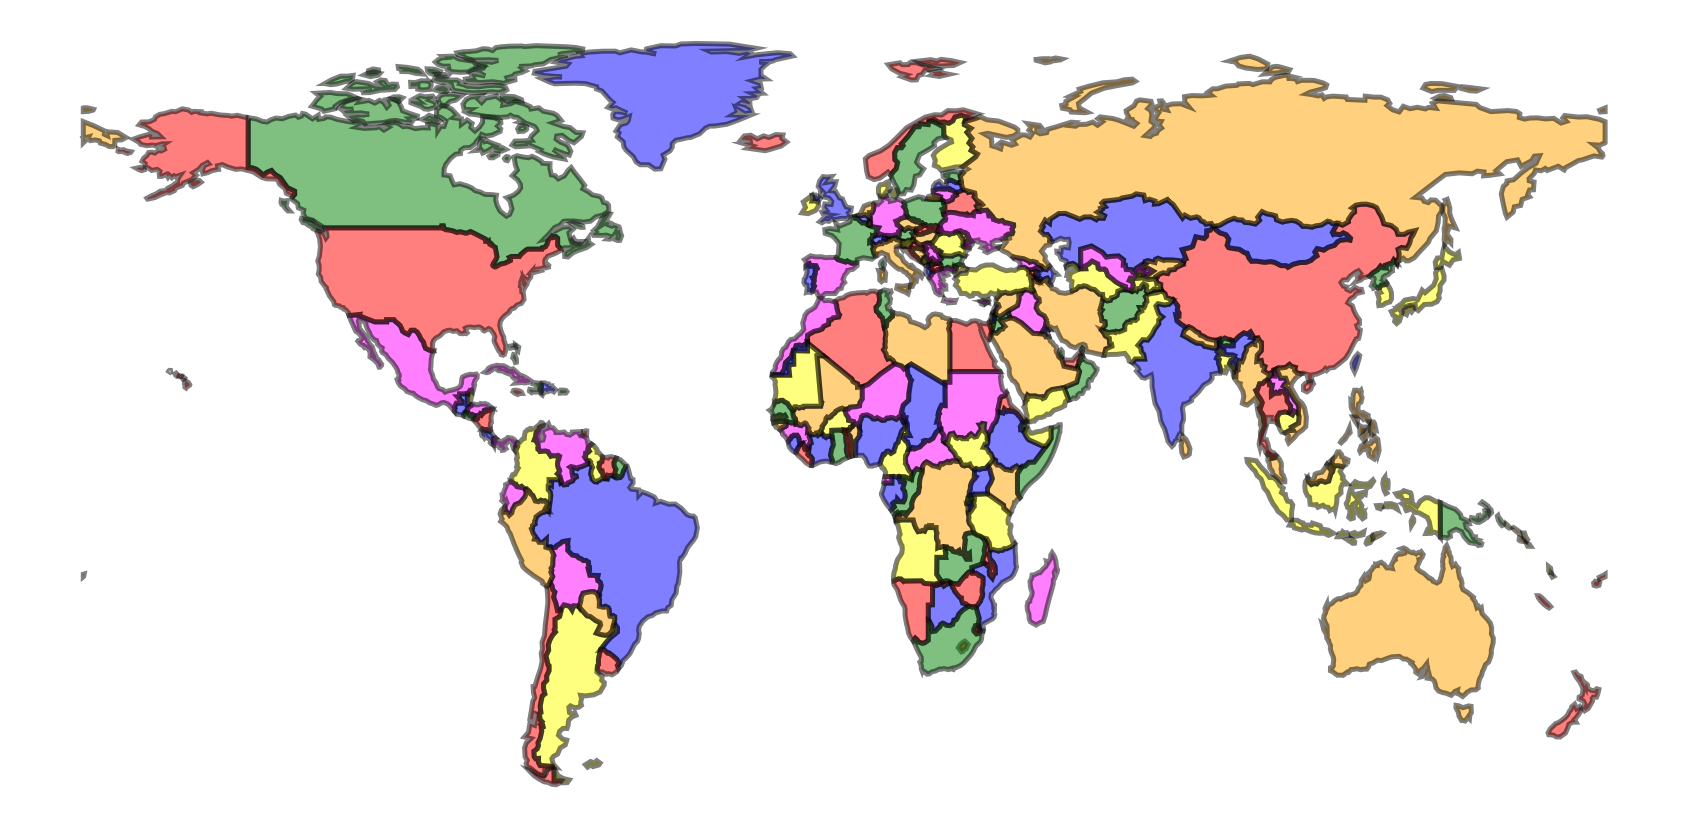

In [31]:
plot_gmap_color(gMap,figsize=(30, 15))

### And that's it! Finally we can draw the graph

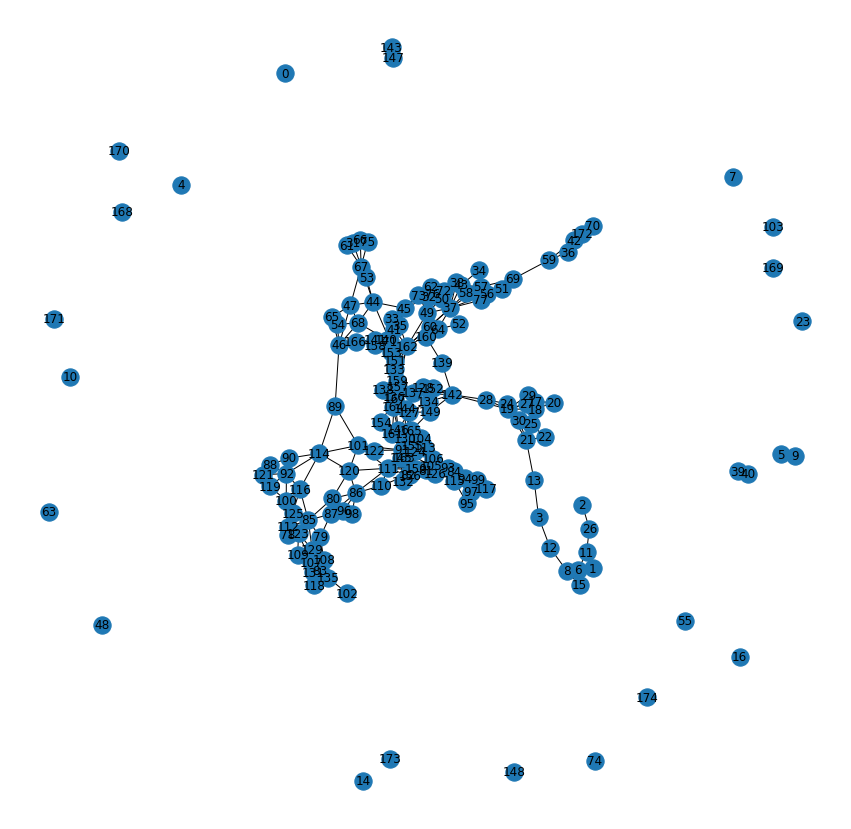

In [411]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(gMap, with_labels=True)